In [ ]:
import numpy as np
import pandas as pd
import warnings
import scipy
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

warnings.filterwarnings('ignore')

#Pre

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_excel('/content/drive/MyDrive/Tugas Akhir/Data/Data Inflasi X dan Y.xlsx', parse_dates=True,
                 index_col=0)
data_index = data.index
df_inflasi = data['Data Inflasi'].values.reshape(-1, 1)
data.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Data Inflasi,X1,X2,X3,X4,X5,X6
Periode,,,,,,,
2010-01-01,3.72,0.00,0.00,0.00,0.00,0.00,0.00
2010-02-01,3.81,3.72,0.00,0.00,0.00,0.00,0.00
2010-03-01,3.43,3.81,3.72,0.00,0.00,0.00,0.00
2010-04-01,3.91,3.43,3.81,3.72,0.00,0.00,0.00
2010-05-01,4.16,3.91,3.43,3.81,3.72,0.00,0.00
2010-06-01,5.05,4.16,3.91,3.43,3.81,3.72,0.00
2010-07-01,6.22,5.05,4.16,3.91,3.43,3.81,3.72
2010-08-01,6.44,6.22,5.05,4.16,3.91,3.43,3.81
2010-09-01,5.80,6.44,6.22,5.05,4.16,3.91,3.43


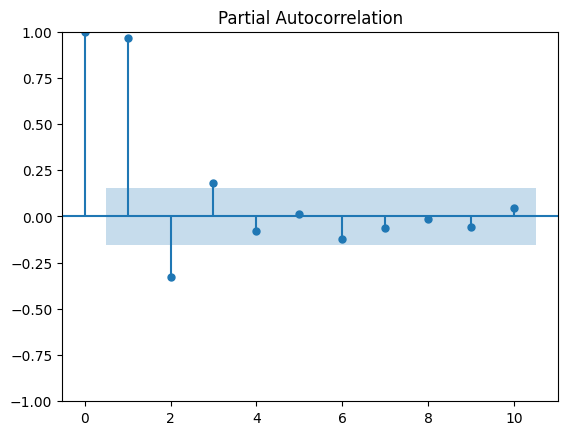

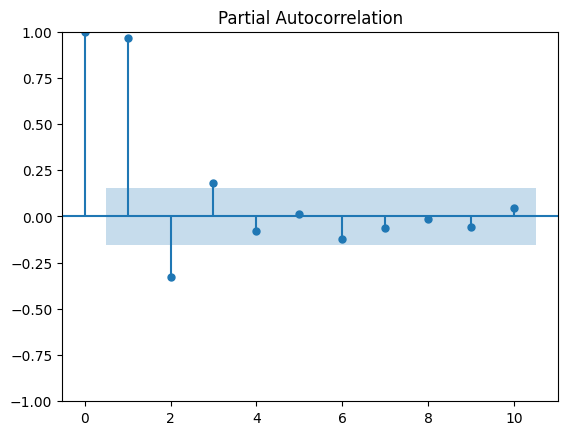

In [ ]:
#Plot PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_inflasi, lags=10, method="yw")

In [ ]:
#Statistik deskriptif
data['Data Inflasi'].describe()

count    159.000000
mean       4.319182
std        1.860984
min        1.320000
25%        3.145000
50%        3.970000
75%        5.555000
max        8.790000
Name: Data Inflasi, dtype: float64

In [ ]:
#Normalisasi Data
svr_x_sc = MinMaxScaler()
svr_y_sc = MinMaxScaler()

scaled = svr_x_sc.fit_transform(df_inflasi)

In [ ]:
#Pembagian variabel respon dan prediktor, serta data training dan testing
x = data[['X1', 'X2', 'X3']]
y = data.iloc[:, 0].values

x_scaled = svr_x_sc.fit_transform(x)
y_scaled = svr_y_sc.fit_transform(y.reshape(-1, 1))

print(x_scaled.shape)
print(y_scaled.shape)

n=len(data)
X_train=x_scaled[:n-32]
Y_train=y_scaled[:n-32]
X_test=x_scaled[-32:]
Y_test=y_scaled[-32:]

(159, 3)
(159, 1)


In [ ]:
Y_train

array([[0.32128514],
       [0.33333333],
       [0.28246319],
       [0.34672021],
       [0.38018742],
       [0.49933066],
       [0.65595716],
       [0.6854083 ],
       [0.59973226],
       [0.58232932],
       [0.67068273],
       [0.75502008],
       [0.76305221],
       [0.73895582],
       [0.71352075],
       [0.64792503],
       [0.62382865],
       [0.56492637],
       [0.44042838],
       [0.46452477],
       [0.44042838],
       [0.41499331],
       [0.37884873],
       [0.33065596],
       [0.31191432],
       [0.29986613],
       [0.35475234],
       [0.42570281],
       [0.41900937],
       [0.42971888],
       [0.43373494],
       [0.43641232],
       [0.40026774],
       [0.44042838],
       [0.40160643],
       [0.39892905],
       [0.43507363],
       [0.53413655],
       [0.61311914],
       [0.56894244],
       [0.55555556],
       [0.61311914],
       [0.97590361],
       [1.        ],
       [0.94779116],
       [0.93708166],
       [0.9437751 ],
       [0.945

In [ ]:
Y_test

array([[0.        ],
       [0.01338688],
       [0.01606426],
       [0.03614458],
       [0.04819277],
       [0.03078983],
       [0.00803213],
       [0.00669344],
       [0.01338688],
       [0.04819277],
       [0.00133869],
       [0.02677376],
       [0.03614458],
       [0.03748327],
       [0.04551539],
       [0.05756359],
       [0.07362784],
       [0.11512718],
       [0.09906292],
       [0.17670683],
       [0.28781794],
       [0.29852744],
       [0.40562249],
       [0.48460509],
       [0.45113788],
       [0.61981258],
       [0.58768407],
       [0.54886212],
       [0.56091031],
       [0.53012048],
       [0.55555556],
       [0.48862115]])

#Uji Linearitas

In [ ]:
#Uji Linearitas
!pip install statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.diagnostic as smd
reg = sm.OLS(y,x).fit()
reset = smd.linear_reset(res=reg, power=2, test_type='fitted', use_f=True)

In [ ]:
print('==correct functional form ramsey reset test==')
print(' ')
print('F-statistic:', np.round(reset.fvalue, 6))
print('p-value:', np.round(reset.pvalue, 6))

==correct functional form ramsey reset test==
 
F-statistic: 4.130744
p-value: 0.043818


#SVR

In [ ]:
#Grid Search-Cross Validation
svrgs_parameters = {
    'kernel': ['rbf'],
    'C':     [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
    'gamma': [0.001, 0.01, 0.1, 1, 1.5, 2],
    'epsilon' : [0.1]
}

svr_cv = GridSearchCV(SVR(), svrgs_parameters, cv=5, scoring= 'neg_mean_absolute_error')
svr_cv.fit(X_train, Y_train)
print("SVR GridSearch score: "+str(svr_cv.best_score_))
print("SVR GridSearch params: ")
print(svr_cv.best_params_)

SVR GridSearch score: -0.06807400764532567
SVR GridSearch params: 
{'C': 1, 'epsilon': 0.1, 'gamma': 2, 'kernel': 'rbf'}


In [ ]:
#Banyaknya SV
svr=SVR(C=1,epsilon= 0.1, gamma= 2)
svr.fit(X_train,Y_train)
svr.n_support_

array([21], dtype=int32)

In [ ]:
#Support vector yang digunakan dalam peramalan
svr.support_vectors_

array([[0.        , 0.        , 0.        ],
       [0.4334471 , 0.42320819, 0.        ],
       [0.5745165 , 0.47326507, 0.44482366],
       [0.64505119, 0.65984073, 0.73265074],
       [0.63026166, 0.68031854, 0.70079636],
       [0.67121729, 0.62229807, 0.63367463],
       [0.97952218, 0.67121729, 0.62229807],
       [1.        , 0.97952218, 0.67121729],
       [0.94653015, 0.9556314 , 1.        ],
       [0.95221843, 0.94653015, 0.9556314 ],
       [0.76222981, 0.83276451, 0.82480091],
       [0.54948805, 0.51535836, 0.45392491],
       [0.70875995, 0.54948805, 0.51535836],
       [0.95108077, 0.70875995, 0.54948805],
       [0.7258248 , 0.71558589, 0.79180887],
       [0.71103527, 0.77701934, 0.81683732],
       [0.55631399, 0.71103527, 0.77701934],
       [0.3811149 , 0.55631399, 0.71103527],
       [0.50625711, 0.50284414, 0.47098976],
       [0.49715586, 0.49260523, 0.47440273],
       [0.22298066, 0.24914676, 0.30375427]])

In [ ]:
#Nilai Beta
svr.dual_coef_

array([[ 0.09493277, -0.00713208,  0.71524597,  1.        , -0.61522117,
         1.        ,  0.27555852,  0.45352218,  1.        ,  0.06181104,
        -1.        ,  1.        ,  1.        , -1.        ,  0.43454349,
        -1.        , -1.        ,  0.31151842, -1.        , -1.        ,
        -0.72477914]])

In [ ]:
#Nilai bias
svr.intercept_

array([0.55205824])

In [ ]:
#Denormalisasi data testing
pred=svr.predict(X_test)
inv_pred = svr_y_sc.inverse_transform(
                    column_or_1d(pred).reshape(-1, 1))
inv_ytest = svr_y_sc.inverse_transform(
                    column_or_1d(Y_test).reshape(-1, 1))
#Uji keakuratan data testing
mse = mean_squared_error(inv_ytest, inv_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(inv_ytest, inv_pred)
mape = mean_absolute_percentage_error(inv_ytest, inv_pred)
print(mape)
print(rmse)
print(mae)

0.29602458048011404
0.6226273271134932
0.571427276704574


In [ ]:
#Denormalisasi data training
predtrain=svr.predict(X_train)
inv_predtrain = svr_y_sc.inverse_transform(
                    column_or_1d(predtrain).reshape(-1, 1))
inv_ytrain = svr_y_sc.inverse_transform(
                    column_or_1d(Y_train).reshape(-1, 1))
testingrbf = pd.DataFrame(inv_pred)
trainingrbf = pd.DataFrame(inv_predtrain)
#Uji keakuratan data training
mse = mean_squared_error(inv_ytrain, inv_predtrain)
rmse = np.sqrt(mse)
mae = mean_absolute_error(inv_ytrain, inv_predtrain)
mape = mean_absolute_percentage_error(inv_ytrain, inv_predtrain)
print(mape)
print(rmse)
print(mae)

0.09541298178622785
0.5515516178394794
0.41750515563420243


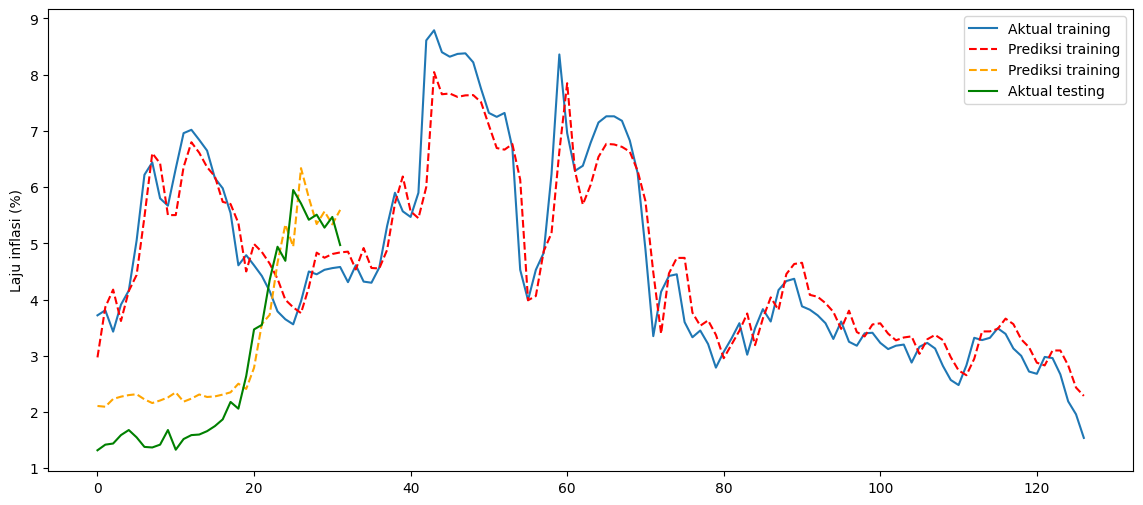

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(inv_ytrain, label='Aktual training')
plt.plot(inv_predtrain, 'k--', color='red', label='Prediksi training')
plt.plot(inv_pred, 'k--', color='orange', label='Prediksi training')
plt.plot(inv_ytest, color='green',label='Aktual testing')
plt.ylabel('Laju inflasi (%)')
plt.legend(loc='best')
plt.show()

#SES

In [ ]:
traindfinflasi=df_inflasi[:n-32]

In [ ]:
testdfinflasi=df_inflasi[-32:]

In [ ]:
error = traindfinflasi-inv_predtrain

In [ ]:
errortrain = pd.DataFrame(error)

In [ ]:
ses_model = SimpleExpSmoothing(errortrain).fit(optimized=True)
#Parameter model SES
ses_model.params

{'smoothing_level': 0.1908791865159895,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 0.16030487842134597,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [ ]:
train_pred_ses = ses_model.fittedvalues
test_pred_ses = ses_model.forecast(32)
trainses = pd.DataFrame(train_pred_ses)
testses = pd.DataFrame(test_pred_ses)

In [ ]:
Hybridtrain = inv_predtrain + trainses

In [ ]:
Hybridtest = inv_pred + testses

In [ ]:
#Uji keakuratan data training
mse = mean_squared_error(traindfinflasi, Hybridtrain)
rmse = np.sqrt(mse)
mae = mean_absolute_error(traindfinflasi, Hybridtrain)
mape = mean_absolute_percentage_error(traindfinflasi, Hybridtrain)
print(mape)
print(rmse)
print(mae)

0.08204724563941744
0.5264317980830475
0.3597723940623154


In [ ]:
#Uji keakuratan data testing
mse = mean_squared_error(testdfinflasi, Hybridtest)
rmse = np.sqrt(mse)
mae = mean_absolute_error(testdfinflasi, Hybridtest)
mape = mean_absolute_percentage_error(testdfinflasi, Hybridtest)
print(mape)
print(rmse)
print(mae)

0.16283706010848947
0.49714743445810833
0.3906991016155712


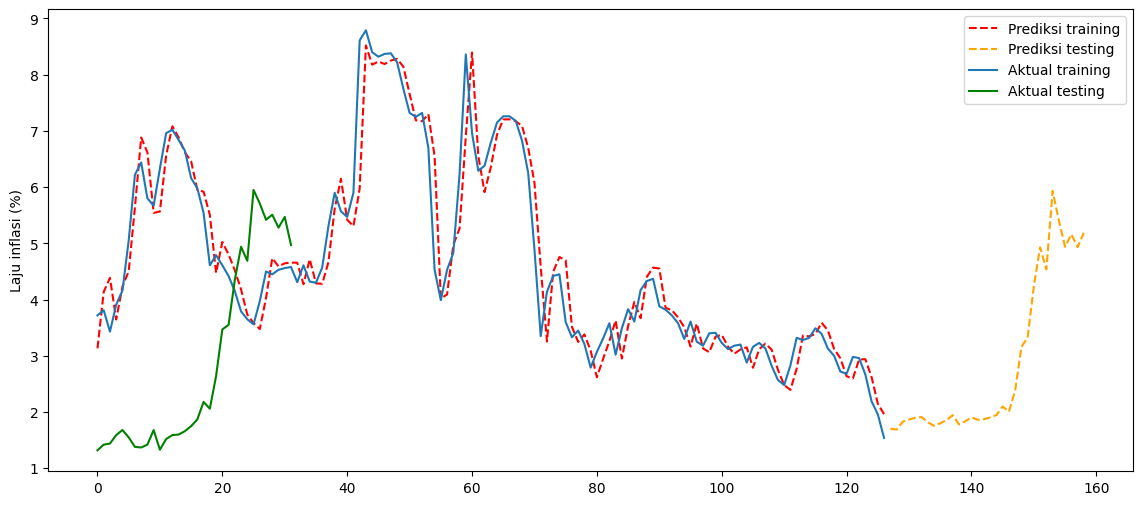

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(Hybridtrain, 'k--', color='red', label='Prediksi training')
plt.plot(Hybridtest, 'k--', color='orange', label='Prediksi testing')
plt.plot(traindfinflasi, label='Aktual training')
plt.plot(df_inflasi[-32:], color='green',label='Aktual testing')
plt.ylabel('Laju inflasi (%)')
plt.legend(loc='best')
plt.show()

In [ ]:
traininflasi =pd.DataFrame(traindfinflasi)
traininflasi

,0
0,3.72
1,3.81
2,3.43
3,3.91
4,4.16
...,...
122,2.96
123,2.67
124,2.19
125,1.96
